## Tutorial 2: Event-based Star Data

***What you will learn***
In this tutorial, we will work with real-world event-based data to learn how to load and process it. 

By the end of this tutorial, you will...
* Be able to load and view event-based star data
* Ignore and remove hot pixels
* Visualise the event-based data as an image
* Calculate the pixel rate of sideral motion




### Loading the data 
Firstly, we will load in the event-based data from the file. For this example, we will load the entire file into memory for speed and convenience. 

In [17]:
import event_stream
import numpy
decoder = event_stream.Decoder("Data/WSU/g4all2022-02-11T09.27.35.es")
events = numpy.concatenate(list(decoder))

### Viewing the data as an accumulated frame

A very useful way to visualise event-based star data is to accumulate all the events in the file together to generate a single frame that captures all the data within the file. This is a very similar method that we used in the previous tutorial to render frames, except that we count the number of events at each pixel instead of just marking whether an event occurred or not. We also apply it across the whole recording. 

This technique works particularly well on star data as it is inherently a sparse dataset. If you were to do the same to the recordings in the previous tutorial, the results would be very hard to interpret. As before, it is important to ensure that the visualisations used are appropriate to the dataset.

We can use the code below to calculate an accumulated frame from the event-based data:

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt

accumulated_frame = numpy.ones((decoder.height, decoder.width))
for t, x, y, p in events:
    accumulated_frame[decoder.height - 1 - y, x] += 1

We can then plot this data using Matlplotlib as follows:

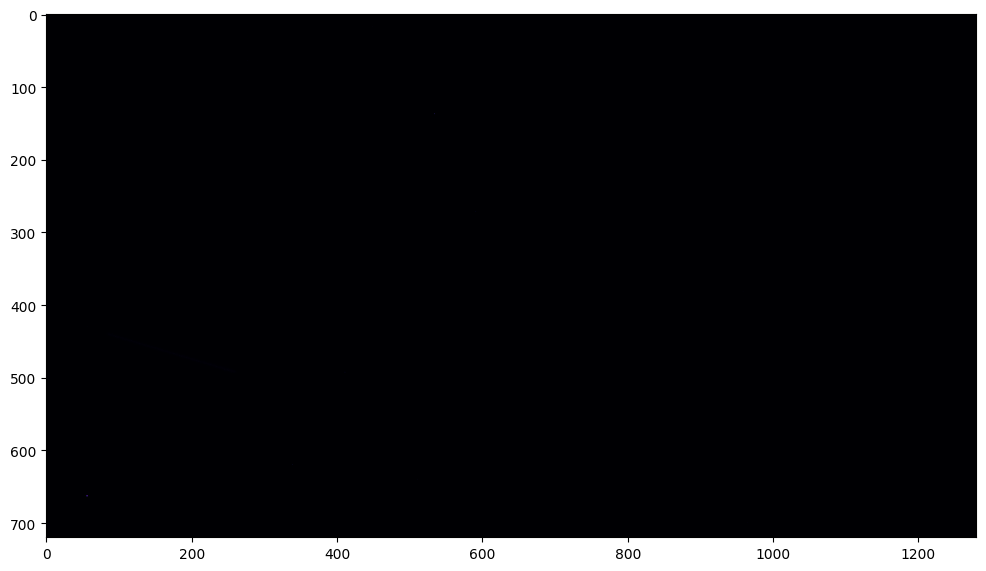

In [12]:

import matplotlib
import matplotlib.colors
import matplotlib.pyplot
import matplotlib.transforms

matplotlib.rcParams["figure.figsize"] = [12, 8]

matplotlib.pyplot.imshow(
    accumulated_frame,
    cmap="magma",
)

And... we get what looks like a blank image. What's happening here?

The problem is one of scale. Let's take a look at a histogram of the number of events per pixel in the above image. We can do that using the following code:

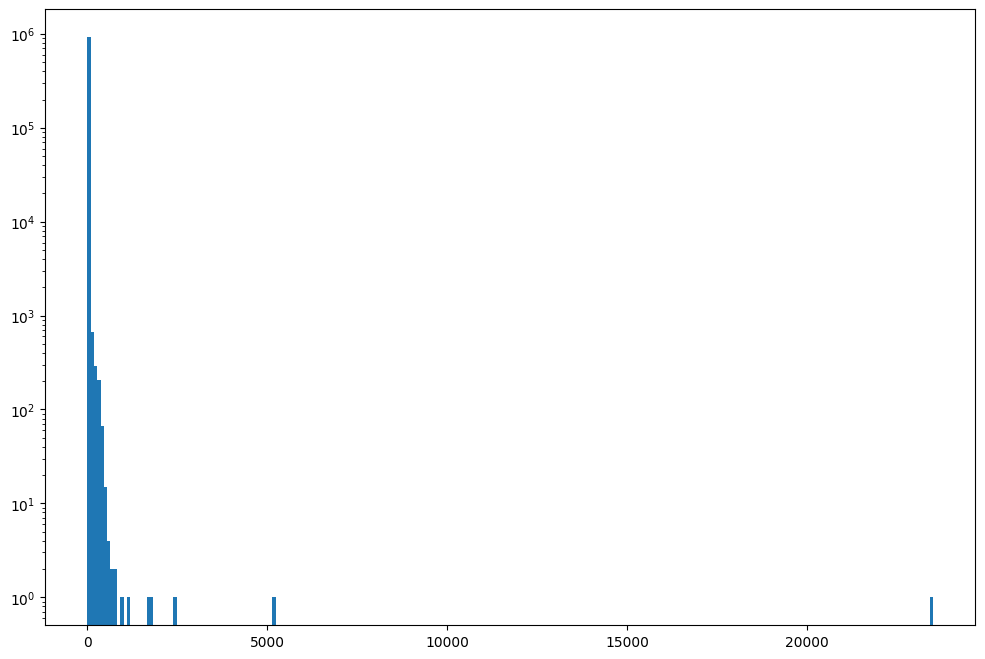

In [15]:
ax = plt.hist(accumulated_frame.ravel(), bins=256)
plt.yscale('log')
plt.show()

Clearly, the event rate is dominated by just a handful of pixels that are generating the majority of the events. These are called Hot Pixels. These are often caused by transistor mismatch. 

If we plot the log of the accumulated value, we can better visualise the data. We can use the following code to better view the starfield:

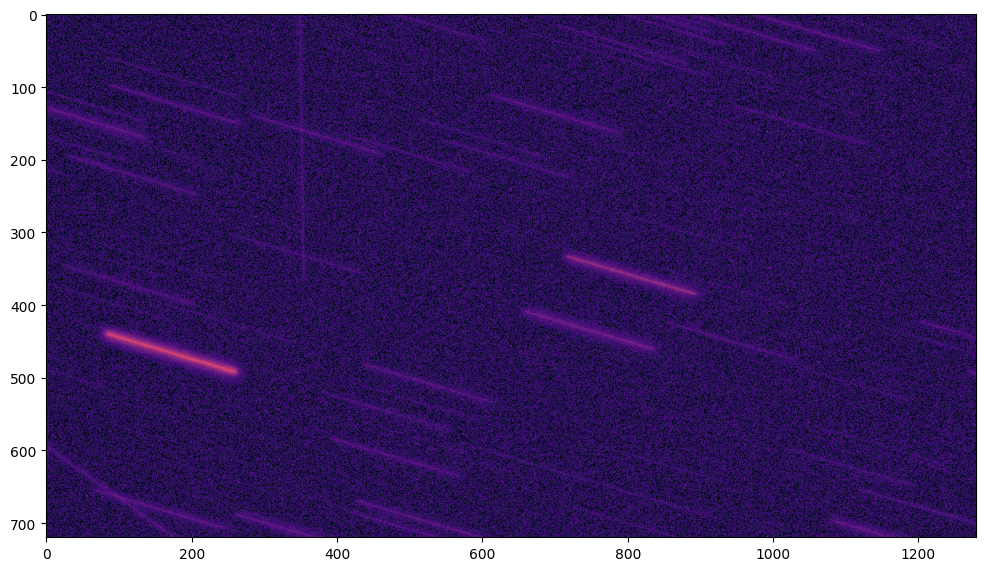

In [23]:
import matplotlib
import matplotlib.colors
import matplotlib.pyplot
import matplotlib.transforms

matplotlib.rcParams["figure.figsize"] = [12, 8]

matplotlib.pyplot.imshow(
    numpy.log(accumulated_frame),
    cmap="magma",
)

However, there is another hidden aspect to the data that isn't show by the accumulated frame. If you watch the rendered video of the data, you will notice that there is a flash of events at the start of the recording. This is due to the camera powering up and adjusting to the scene dynamics. If you look at a plot of the event rate, you can clearly see the impact of this burst of events:

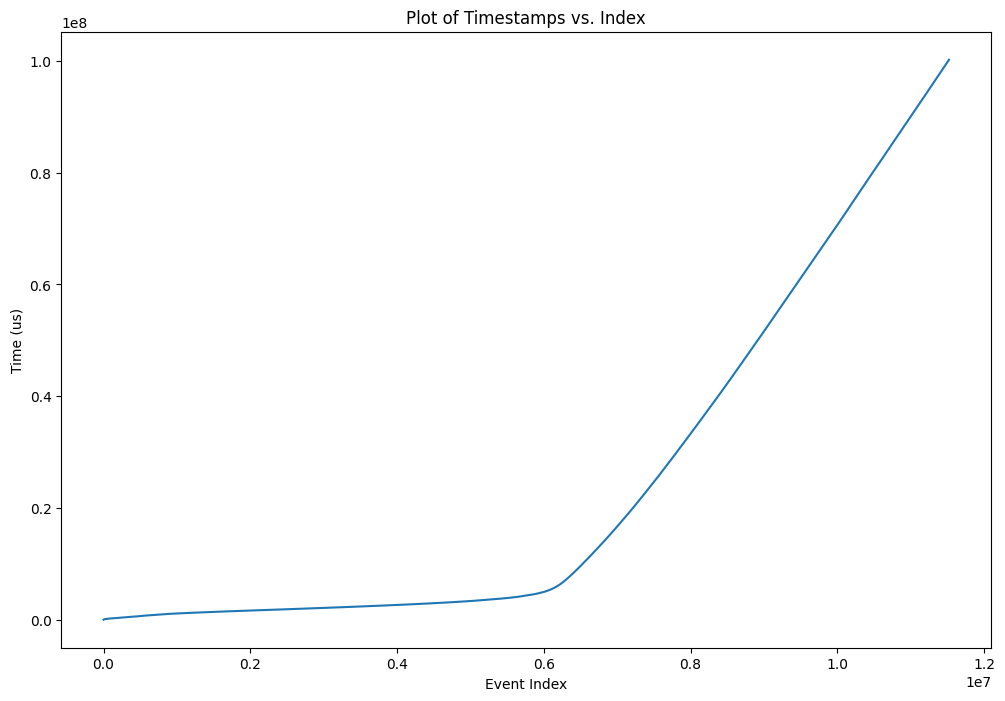

In [8]:
%matplotlib inline

import event_stream
import matplotlib.pyplot as plt

decoder = event_stream.Decoder("Data/WSU/g4all2022-02-11T09.27.35.es")

timestamps = []
for packet in decoder:
    for t, x, y, p in packet:
        timestamps.append(t)

plt.plot(timestamps)
plt.xlabel("Event Index")
plt.ylabel("Time (us)")
plt.title("Plot of Timestamps vs. Index")
plt.show()

The timestamps grow very slowly over time for the first 6,000,000 events ($6e6$ events) and then start increasing more rapidly after that point. That indicates that a significant number of events were generated over a relatively short period of time. This data isn't terribly useful to us at present, so we can remove that data by simply plotting the events occurring after that index. 

We can use the code below to do that:

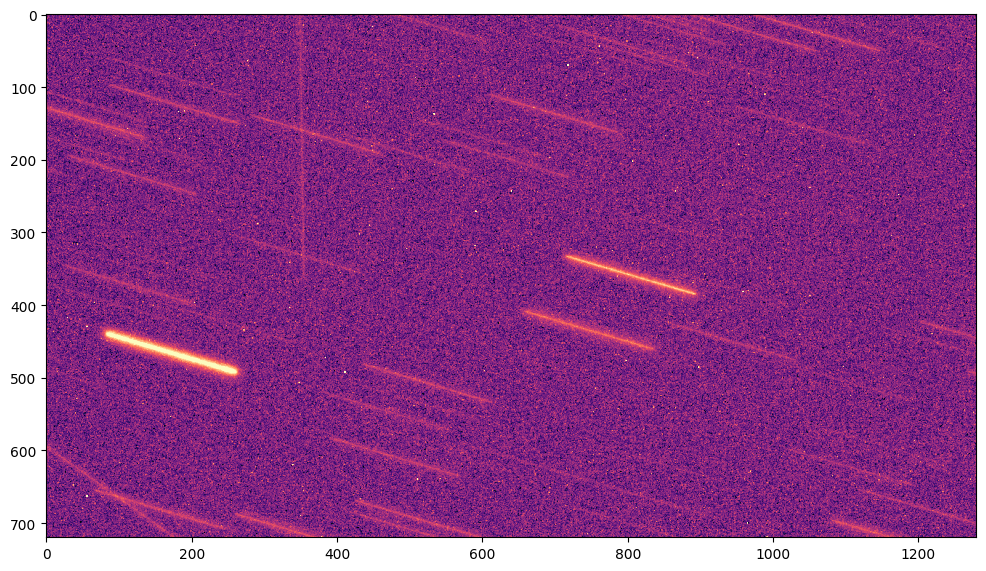

In [11]:

accumulated_frame = numpy.ones((decoder.height, decoder.width))
for t, x, y, p in events[6000000:]:
    accumulated_frame[decoder.height - 1 - y, x] += 1


matplotlib.rcParams["figure.figsize"] = [12, 8]
matplotlib.pyplot.imshow(
    accumulated_frame,
    norm=matplotlib.colors.LogNorm(vmax=numpy.percentile(accumulated_frame, 99.9)),
    cmap="magma",
)

The plotted data does not look significantly different, despite us dropping about 6 million events from the data. For convenience sake, we have already removed this noisy data and saved the result as `/Data/WSU/g4all2022-02-11T09.27.35_cut.es`. We will use this shortened version fo the data in the next tutorial.

### Calculating the sidereal rate for the data

Let's now try to calculate the sidereal rate of movement of the stars in pixel coordinates. We will need this value in order to perform the event-warping needed to extract star positions from this data. 

The simplest means to calculate this value is to measure it by hand. To do this, we will extract a short extract of the recording. We will start by extracting about 4,000,000 events. Given that the sidereal rate is relatively constant, we could pick any length recording to do so.

We can then plot the extracted section as follows:

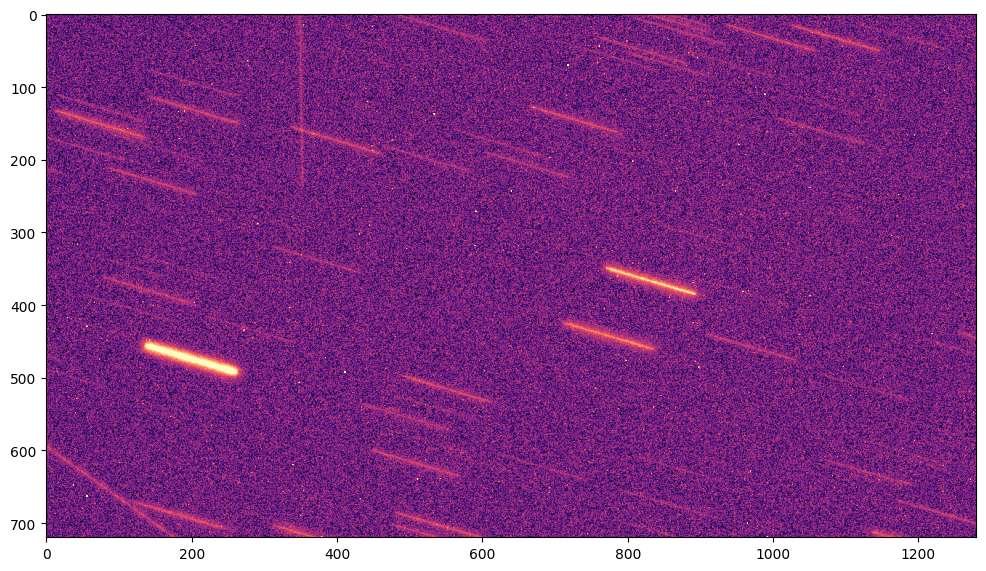

In [64]:
accumulated_frame = numpy.ones((decoder.height, decoder.width))
for t, x, y, p in events[6000000:10000000]:
    accumulated_frame[decoder.height - 1 - y, x] += 1


matplotlib.rcParams["figure.figsize"] = [12, 8]
matplotlib.pyplot.imshow(
    accumulated_frame,
    norm=matplotlib.colors.LogNorm(vmax=numpy.percentile(accumulated_frame, 99.9)),
    cmap="magma",
)

Now, let's pick a streak and extract a small region around it. We will pick the streak located around $(350, 800)$ in the image. We can extract and plot this portion of our extracted recording using the following:

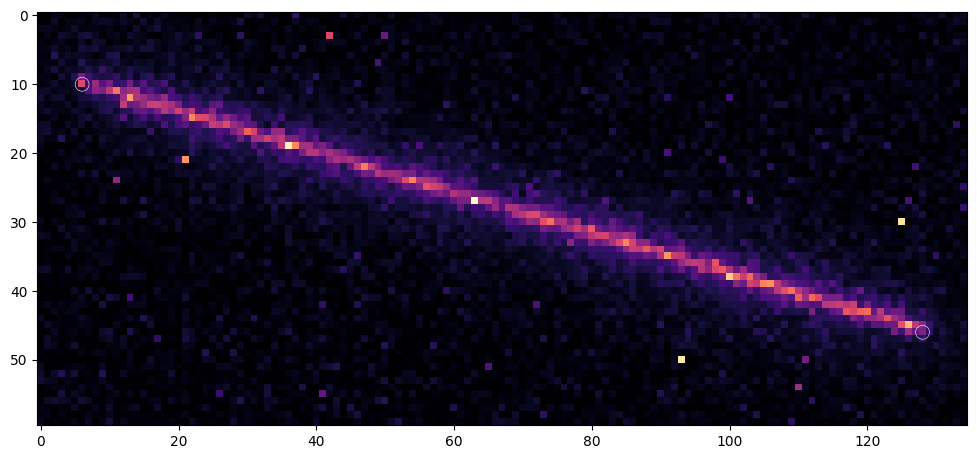

In [128]:

matplotlib.rcParams["figure.figsize"] = [12, 8]

matplotlib.pyplot.imshow(
    accumulated_frame[340:400,765:900],
    cmap="magma",
)

start_point = [6, 10]
end_point = [128, 46] 

matplotlib.pyplot.scatter(
    x=[start_point[0], end_point[0]],
    y=[start_point[1], end_point[1]],
    marker="o",
    facecolor="none",
    edgecolors="#ffffff",
    linewidth=0.4,
    s=100,
)

We can then easily calculate the sidereal motion by finding the starting and end points of the streak and dividing by the elapsed time. Keep in mind that we used the indices to extract a portion of the recording, and not the actual time, therefore we need to extract the time from the event at the index corresponding to the start and end of our extracted range.

We can then calculate the pixel speed of the sidereal motion as follows:

In [ ]:
start =[events[6000000]['t'], 6,9]
end = [events[10000000]['t'],128, 46]

dt = events[10000000]['t'] - events[6000000]['t']
dx = end_point[0] - start_point[0]
dy = end_point[1] - start_point[1]
print(f"dt: {dt} uS")
print(f"dx/dt: {(dx / dt) * 1e6} pixels per second")
print(f"dy/dt: {(dy / dt) * 1e6} pixels per second")

We will use this in the next tutorial to perform the star mapping.